
# Reproduction of Deep learning improves prediction of drug–drug and drug–food interactions<sup>[1]</sup>
---
Team: **Ahmad Sadeed** (asadeed2), **Andrew Vamos** (avamos2), **Jonathon Green** (jg70)

Date: May 7, 2024

Overview: This Google Colab Jupyter notebook contains a demonstration of how the model for the original paper by Ryu et al<sup>[1]</sup> can be trained successfully using the ChemicalX DDI Python package<sup>[2]</sup>. Here, we demonstrate successful training of a small sized model within Colab, then load in fully trained models (via gdown) which were trained locally and plot their performance.

## Install Packages

In [1]:
import os
from IPython.display import display, Javascript

prebuilt = False
arch_x86_64 = True

if prebuilt and arch_x86_64:

  def show_alert(message):
      js_code = f"alert('{message}');"
      display(Javascript(js_code))

  # Packages needed for the prebuilt wheels
  !pip install wheel

  # PyTDC-0.4.1-py3-none-any.whl # This package prompts the user to restart the session after it's installed
  show_alert("Please do not restart this session when prompted.")
  !wget -O PyTDC-0.4.1-py3-none-any.whl https://drive.usercontent.google.com/download?id=1JbHuCkbLIp9BTbNlj3MB75WfTbz_HUkN&export=download&authuser=0
  !pip install PyTDC-0.4.1-py3-none-any.whl

  # torch_cluster-1.6.3-cp310-cp310-linux_x86_64.whl
  !wget -O torch_cluster-1.6.3-cp310-cp310-linux_x86_64.whl https://drive.usercontent.google.com/download?id=18p4c1tfkp_-xX7OMbDrhFDYK3viefOsY&export=download&authuser=0
  !pip install torch_cluster-1.6.3-cp310-cp310-linux_x86_64.whl

  # torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl
  !wget -O torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl https://drive.usercontent.google.com/download?id=1wi-QdBqogm2K0UG-V-oZLImJw9kSWQaL&export=download&authuser=0
  !pip install torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl

  # chemicalx-0.1.0-py3-none-any.whl
  !wget -O chemicalx-0.1.0-py3-none-any.whl https://drive.usercontent.google.com/download?id=1ZuzW7nq1QPHkXZH9keyvWmxm1eHpYqyq&export=download&authuser=0
  !pip install chemicalx-0.1.0-py3-none-any.whl

else:
  !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
  !pip install torch-scatter -f https://data.pyg.org/whl/torch-2.2.2+cu121.html
  !pip install torch-cluster -f https://data.pyg.org/whl/torch-2.2.2+cu121.html

  # The official package requires 3.8, we're using a fork that's 3.10 compatiable
  !pip install git+https://github.com/lucag2/chemicalx#egg=chemicalx # ref [3]

# other packages
!pip install torchinfo plotly torchsummary ipykernel gdown
!pip install --upgrade nbformat

Looking in indexes: https://download.pytorch.org/whl/cu121

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Looking in links: https://data.pyg.org/whl/torch-2.2.2+cu121.html

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Looking in links: https://data.pyg.org/whl/torch-2.2.2+cu121.html


# Introduction

Drug-drug interactions (DDIs) and drug-food interactions (DFIs) significantly impact patient safety and treatment efficacy, presenting complex challenges in pharmacology. Predicting these interactions is crucial but difficult due to the extensive data requirements and often poorly understood mechanisms involved.

The paper by Jae Yong Ryu, Hyun Uk Kim, and Sang Yup Lee<sup>[1]</sup> introduces DeepDDI, a computational framework that uses deep learning to predict DDIs and DFIs from basic drug names and structural information. This method significantly advances the state of the art by not only predicting the occurrence of drug interactions but also describing their potential pharmacological effects in human-readable terms, achieving a mean accuracy of 92.4% across 86 DDI types with the DrugBank<sup>[4]</sup> dataset.

DeepDDI's innovative approach enhances understanding of drug interactions, supports informed clinical decisions, and offers potential mitigation strategies for adverse effects, marking a substantial contribution to the field.Development of models such as DeepDDI should lead to improved safety around drug administration, particularly as new drugs are introduced to the medical community.

Our project aims to replicate the findings of Ryu et al<sup>[1]</sup>. to assess the reproducibility of DeepDDI in a standard computational environment like Google Colab, highlighting its practical implications for improving drug safety and therapeutic strategies.


# Scope of Reproducibility:

Our project seeks to validate critical aspects of the DeepDDI model proposed by Ryu et al<sup>[1]</sup>. to assess its practicality, accuracy, and usability in predicting drug-drug and drug-food interactions using a standard computational environment. The following hypotheses from the original paper will be tested with corresponding experiments:

**Hypothesis**: DeepDDI can predict drug-drug interactions with high accuracy using only drug names and structural information as inputs.

* Experiment: We will replicate the model using the same dataset from DrugBank<sup>[4]</sup> used in the original study. Our experiment will involve retraining the DeepDDI model within our environment (Google Colab) and comparing the prediction accuracy with the reported mean accuracy of 92.4%. This test will confirm if DeepDDI maintains its efficacy across different computational setups.



# Methodology

This section is organized into two primary subsections: Data and Model, which together describe the comprehensive framework of our experimental setup.


* Data: This subsection details the source, structure, and processing of the data used in our experiments, ensuring transparency and reproducibility in how data is handled and prepared for modeling.
* Model: This subsection describes the architecture, training, and evaluation of the model. It includes the specific configurations tested, the training process, and the techniques used for model validation.

Each part is accompanied by annotated code snippets that not only execute the described procedures but also clarify the purpose and functionality of each step in the process.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import time
import torch
from chemicalx.models import DeepDDI
from chemicalx.data import BatchGenerator, DrugbankDDI
import collections.abc
import collections.abc
import json
from dataclasses import dataclass
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
from class_resolver import FunctionResolver
from pathlib import Path
from typing import List, Mapping, Optional, Sequence, Union
import pandas as pd
from tabulate import tabulate
from tqdm import trange
from chemicalx.models import Model
from chemicalx.version import __version__

/home/jon/.pyenv/versions/3.10.14/envs/final-project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
metric_resolver = FunctionResolver([])
metric_resolver.register(roc_auc_score, synonyms={"roc_auc", "auc_roc", "auroc"})
metric_resolver.register(accuracy_score, synonyms={"acc", "accuracy"})
metric_resolver.register(recall_score, synonyms={"recall"})
metric_resolver.register(precision_score, synonyms={"precision"})
metric_resolver.register(f1_score, synonyms={"f_score", "f1"})

@dataclass
class Result:
    """A result package."""

    model: Model
    predictions: pd.DataFrame
    losses: List[float]
    train_time: float
    evaluation_time: float
    metrics: Mapping[str, float]

    def summarize(self) -> None:
        """Print results to the console."""
        print(tabulate(sorted(self.metrics.items()), headers=["Metric", "Value"]))

    def save(self, directory: Union[str, Path]) -> None:
        """Save the results to a directory."""
        if isinstance(directory, str):
            directory = Path(directory)
        directory = directory.resolve()
        directory.mkdir(exist_ok=True, parents=True)

        torch.save(self.model, directory.joinpath("model.pkl"))
        directory.joinpath("results.json").write_text(
            json.dumps(
                {
                    "evaluation": self.metrics,
                    "losses": self.losses,
                    "training_time": self.train_time,
                    "evaluation_time": self.evaluation_time,
                    "chemicalx_version": __version__,
                },
                indent=2,
            )
        )

##  Data
Our project utilizes a comprehensive dataset derived from DrugBank<sup>[4]</sup>, specifically focusing on drug-drug interactions (DDIs). DrugBank<sup>[4]</sup> is a rich bioinformatics and cheminformatics resource that contains detailed drug data including chemical, pharmacological, and pharmaceutical drug information.

### Source of the Data:
The data for this study is collected from the DrugBank<sup>[4]</sup> database, which provides an extensive array of drug interaction data along with descriptive drug properties. This database is widely used in pharmacological research for both academic and industrial purposes. The data used in this project can be accessed through the DrugBank API directly through ChemicalX<sup>[2]</sup> or by downloading the data directly from [DrugBank's website](https://www.drugbank.ca/)<sup>[4]</sup>.

### Statistics:
The dataset comprises features for structural similarity profiles of 1706 drugs. A single SSP is a pairwise similarity score between a given drug and 2,159 other DrugBank drug. In total, the dataset includes:

* 1706 drugs total
* 86 possible drug-drug interaction types (termed contexts)
* SSP feature vectors for each drug of length 2159. This can be reduced down for smaller model sized. The original paper used only 50 SSP features for each drug in a given pair, for a 100 length feature total. PCA was used to chose the 50 features
* Labeled triples of drug interactions, i.e. triples consiting of [DrugA, DrugB, Context, Label] indicating for a given pair of drugs whether or not a certain interaction is present.
* In total, 192,284 DDIs exist for 191,878 drug pairs across the 86 context types.
* For training our model, the dataset was divided into a training set (80% of the data), a validation set (10%), and a test set (10%). This split ensures robust testing and validation of the model across unseen data.

### Data Process:
The data was manipulated as follows:

* The dataset was first loaded using a specialized loader that organizes context features, drug features, and labeled triples indicating interactions.
* The full dataset was then split into training, validation, and test sets to evaluate the model's performance and prevent overfitting.
* Each set is used to create batches of data, which are fed into the model during the training and evaluation phases. These batches include only the drug features to predict interactions, without considering context features or molecular structures.

In [ ]:
loader = DrugbankDDI()
context_set = loader.get_context_features()
drug_set = loader.get_drug_features()
triples = loader.get_labeled_triples()
loader.summarize()

# 60% train, 40% test and validation
train, test_val = triples.train_test_split(train_size=0.6)

# split the 40% test/validation in half (i.e. 20% test and 20% validation)
val, test = test_val.train_test_split(train_size=0.5)

print("train:", len(train))
print("test:", len(val))
print("test:", len(test))

batch_size = 256
train_generator = BatchGenerator(batch_size=batch_size,
                           context_features=False,
                           drug_features=True,
                           drug_molecules=False,
                           context_feature_set=context_set,
                           drug_feature_set=drug_set,
                           labeled_triples=train)
val_generator = BatchGenerator(batch_size=batch_size,
                                 context_features=False,
                                 drug_features=True,
                                 drug_molecules=False,
                                 context_feature_set=context_set,
                                 drug_feature_set=drug_set,
                                 labeled_triples=val)
test_generator = BatchGenerator(batch_size=batch_size,
                               context_features=False,
                               drug_features=True,
                               drug_molecules=False,
                               context_feature_set=context_set,
                               drug_feature_set=drug_set,
                               labeled_triples=test)

Name: DrugbankDDI
Contexts: 86
Context Feature Size: 86
Drugs: 1706
Drug Feature Size: 256
Triples: 383616

train: 306892
test: 38362
test: 38362


In [ ]:
import plotly.express as px

# Data for plotting
labels = ['Train', 'Validation', 'Test']
sizes = [len(train), len(val), len(test)]
df = pd.DataFrame({'Split': labels, 'Size': sizes})

fig = px.pie(df, values='Size', names='Split', title='Data Distribution')
fig.show()

##   Model
Our project utilizes a deep learning architecture designed specifically for predicting drug-drug interactions (DDIs) from drug features. The model's architecture and training processes are detailed below:

### Model Architecture:

* Layer Configuration: The model is composed of several hidden layers. The number of hidden layers is set dynamically, with experiments run using 8 layers. Each layer utilizes fully connected (dense) neural layers.
* Channels and Nodes: The input drug features are processed through drug_channels, which is determined by the data loader. The number of hidden channels per layer is variable, tested with configurations including 128 nodes.
* Output: The model outputs a single value per drug pair, representing the probability of interaction, which is then thresholded to classify interactions.
* Activation Function: The architecture uses ReLU (Rectified Linear Unit) activation functions throughout the hidden layers to introduce non-linearity, beneficial for learning complex patterns.

### Training Objectives:

* Loss Function: The model uses the Binary Cross-Entropy Loss (BCELoss), a common choice for binary classification tasks.
* Optimizer: Adam optimizer is employed for its efficiency in handling sparse gradients and adaptive learning rate capabilities.
* Learning Rate and Epochs: The learning rate is set at 0.0001 with experiments conducted over 100 epochs.

### Additional Configuration:

* Thresholding: Post-prediction, a threshold of 0.47 is applied to convert the probabilistic outputs into binary interaction predictions.

### Code Implementation:
The model is encapsulated within a training function that handles the full lifecycle of training and validation. This function initializes the model, sets up the loss criterion and optimizer, and performs epoch-wise training with backpropagation. Post-training, the model is evaluated on a validation set, and metrics such as ROC-AUC, accuracy, recall, precision, and F1 score are calculated to assess performance.

In [ ]:
def train_fnc(_drug_channels=256,
          _hidden_channels=2048,
          _hidden_layers_num=8,
          _out_channels=1,
          _lr=0.0001,
          _epochs=100,
          _threshold=0.47,
          metrics: Optional[Sequence[str]] = None):

    ddi_model = DeepDDI(
        drug_channels=_drug_channels,
        hidden_channels=_hidden_channels,
        hidden_layers_num=_hidden_layers_num,
        out_channels=_out_channels
    )

    optimizer = torch.optim.Adam(ddi_model.parameters(), lr=_lr)
    ddi_model.train()
    criterion = torch.nn.BCELoss()
    losses = []
    train_start_time = time.time()

    for epoch in trange(_epochs):
        for training_batch in train_generator:
            optimizer.zero_grad()
            training_prediction = ddi_model(training_batch.drug_features_left, training_batch.drug_features_right)
            loss = criterion(training_prediction, training_batch.labels)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
        # print(f"Epoch {epoch}: epoch_loss={np.mean(losses)}")

    train_time = time.time() - train_start_time

    ddi_model.eval()
    predictions = []
    evaluation_start_time = time.time()

    for val_batch in val_generator:
        prediction = ddi_model(val_batch.drug_features_left, val_batch.drug_features_right)
        if isinstance(prediction, collections.abc.Sequence):
            prediction = prediction[0]
        prediction = prediction.detach().cpu().numpy()
        identifiers = val_batch.identifiers
        prediction[prediction >= _threshold] = 1
        prediction[prediction < _threshold] = 0
        identifiers["prediction"] = prediction
        predictions.append(identifiers)

    evaluation_time = time.time() - evaluation_start_time
    predictions_df = pd.concat(predictions)

    if metrics is None:
        metric_dict = {"roc_auc": roc_auc_score}
    else:
        metric_dict = {name: metric_resolver.lookup(name) for name in metrics}

    return Result(
        model=ddi_model,
        predictions=predictions_df,
        losses=losses,
        train_time=train_time,
        evaluation_time=evaluation_time,
        metrics={
            name: func(predictions_df["label"], predictions_df["prediction"]) for name, func in metric_dict.items()
        },
    )

### Training a Simplified Model for Demonstration

To demonstrate the training process and model architecture interactively within this notebook, we will train a simplified version of our deep learning model. This streamlined model will utilize fewer resources, making it feasible to train interactively without extensive computational demands.

The simplified model will have the following adjustments for efficient demonstration:

* Node Configuration: Each layer will consist of only 128 nodes, reducing the complexity of the model.
* Epochs: The training will be conducted over only one epoch to provide a quick insight into the model's learning behavior without waiting for extended periods.

This approach is intended to give a practical overview of the model's functionality and training dynamics while not replacing the need for full-scale training performed outside this notebook. The code below initializes and trains this model, and briefly evaluates its performance:

In [ ]:
metrics=["roc_auc", "acc", "recall", "precision", "f1"]
drug_channels = loader.drug_channels
hidden_nodes = [128]  # -->[128, 256, 512, 1024, 2048] <-- versions we pretrained which will be loaded below
hidden_layers = 8
epochs = 1 # 100 epochs used in the original paper and our pretrained versions
lr=0.0001

start = time.time()
for node in hidden_nodes:
    print(f"\nTraining with {hidden_layers} layers and {node} nodes:")
    result = train_fnc(_drug_channels=drug_channels,
                   _hidden_channels=node,
                   _hidden_layers_num=hidden_layers,
                   _out_channels=1,
                   _lr=lr,
                   _epochs=epochs,
                   metrics=metrics)
    result.summarize()
    result_dir = f"./results_{node}_node/"
    result.save(result_dir)

time_taken = time.time() - start
print("time taken:", time_taken)


Training with 8 layers and 128 nodes:


100%|██████████| 1/1 [00:16<00:00, 16.90s/it]


Metric        Value
---------  --------
acc        0.571712
f1         0.681466
precision  0.542472
recall     0.916224
roc_auc    0.571694
time taken: 19.12507390975952


### Model Loading and Evaluation

Due to the computational intensity and time constraints associated with training our deep learning model for predicting drug-drug interactions, we have pre-trained the model outside of this notebook. This approach allows us to utilize more powerful computational resources and ensure the model is thoroughly trained without the limitations of this interactive environment.

Below, we provide the code to load the pre-trained model and the saved results of its performance on a set of test data using the test, validation, and train scheme above. Note that these validation metrics were generated at runtime of the original training of the model since we did not save the data folds as selected by the dataloader for this demonstration on Colab.

Strategically subsetting data into train, validation, and test folds is crucial for demonstrating the model’s effectiveness and ensuring that it generalizes well to new, unseen data.


In [ ]:
# LOAD PRETRAINED MODELS

import gdown

node_list = [128, 256, 512, 1024, 2048]
file_id = {"128":"1e03P--Qo_aJZL670o0OD4HNGqh6CLEHy",
           "256":"1lCbv0ZzfGgmFY274FllRENSzkTYuA3So",
           "512":"166cPKwsydG_Z-9afpqeBuB6ZUaPDB0zY",
           "1024":"141IpugQZpsRX27VxnOPeAzGK5gUt3YTz",
           "2048":"1TdfpohPb5RjCZ1V8XZiMJQDNLo-qFWV0"}

def load_model( file_id, nodes):
  """Accepts a file ID and node count to load in a DeepDDI model from gdrive"""

  url = f"https://drive.google.com/uc?id={file_id}"
  output = f"model_{nodes}.pkl"
  gdown.download(url, output, quiet=False)
  my_model = torch.load(output)
  my_model.eval()
  return my_model

#loading in the torch.save pkl file
trained_models = [load_model(file_id[str(node)], node) for node in node_list]

Downloading...
From: https://drive.google.com/uc?id=1e03P--Qo_aJZL670o0OD4HNGqh6CLEHy
To: /home/jon/Development/source/final-project-deepddi/model_128.pkl
100%|██████████| 764k/764k [00:01<00:00, 556kB/s]
Downloading...
From: https://drive.google.com/uc?id=1lCbv0ZzfGgmFY274FllRENSzkTYuA3So
To: /home/jon/Development/source/final-project-deepddi/model_256.pkl
100%|██████████| 2.42M/2.42M [00:02<00:00, 1.08MB/s]
Downloading...
From: https://drive.google.com/uc?id=166cPKwsydG_Z-9afpqeBuB6ZUaPDB0zY
To: /home/jon/Development/source/final-project-deepddi/model_512.pkl
100%|██████████| 8.49M/8.49M [00:03<00:00, 2.54MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=141IpugQZpsRX27VxnOPeAzGK5gUt3YTz
From (redirected): https://drive.google.com/uc?id=141IpugQZpsRX27VxnOPeAzGK5gUt3YTz&confirm=t&uuid=465b7be5-1d24-4772-80ff-c0b407bcc5bb
To: /home/jon/Development/source/final-project-deepddi/model_1024.pkl
100%|██████████| 31.6M/31.6M [00:06<00:00, 4.53MB/s]
Downloading...
From (or

### 128 Node Model Architechture

In [ ]:
#display model architecture for 128
print('/n Architecture for 128 node model: /n')
print(trained_models[0])

/n Architecture for 128 node model: /n
DeepDDI(
  (final): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=None, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=None, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(128, eps=1e-05, momentum=None, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(128, eps=1e-05, momentum=None, affine=True, track_running_stats=True)
    (15): ReLU()
    (16): Linear(in_features=128, out_features=128, bias=True)
    (17): ReLU()
    (18): BatchNorm1d(128, eps=1e-05, momentum=None, affine=True, track_running_stats=True)
    (19): R

### 2048 Node Model Architechture

In [ ]:
#display model architecture for 2048
print('/n Architecture for 2048 node model: /n')
print(trained_models[-1])

/n Architecture for 2048 node model: /n
DeepDDI(
  (final): Sequential(
    (0): Linear(in_features=512, out_features=2048, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(2048, eps=1e-05, momentum=None, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=2048, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(2048, eps=1e-05, momentum=None, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Linear(in_features=2048, out_features=2048, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(2048, eps=1e-05, momentum=None, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=2048, out_features=2048, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(2048, eps=1e-05, momentum=None, affine=True, track_running_stats=True)
    (15): ReLU()
    (16): Linear(in_features=2048, out_features=2048, bias=True)
    (17): ReLU()
    (18): BatchNorm1d(2048, eps=1e-05, momentum=None, affine=True, track_running_stats=Tr

# Results
This section provides a comprehensive overview of the outcomes from both our simplified model trained within this notebook and the pre-trained model loaded from external resources. The results are presented through quantitative metrics and visual representations to clearly demonstrate the model's effectiveness and performance.

## Results from the Pre-trained Model Evaluation

After loading the pre-trained model, we evaluated it on a designated test set to assess its generalization capability. This model was trained with the full configuration on extensive computational resources.

The following metrics were saved from the training of our preloaded 
 models via the training code demonstrated above. 

Runtime results for model_128:
ROC AUC: 0.7107919675956202
Accuracy: 0.7107815025285439
Recall: 0.5100615160045876
Precision: 0.8521905757338211
F1 Score: 0.6381632586504908
Training Time (s): 1492.631842136383
losses: [0.7487072944641113, 0.728279173374176, 0.6894834637641907] ... [0.2382315695285797, 0.16804464161396027, 0.18807879090309143]
Runtime results for model_256:
ROC AUC: 0.8146608949409363
Accuracy: 0.8146603409624107
Recall: 0.8040350328432906
Precision: 0.8215084691594758
F1 Score: 0.812677837496048
Training Time (s): 2318.332372903824
losses: [0.8192499876022339, 0.7741400003433228, 0.7977485060691833] ... [0.08452069759368896, 0.06843753904104233, 0.13147076964378357]
Runtime results for model_512:
ROC AUC: 0.8352013787256454
Accuracy: 0.8352015014858454
Recall: 0.8375560421228235
Precision: 0.8336446658364467
F1 Score: 0.8355957767722474
Training Tim

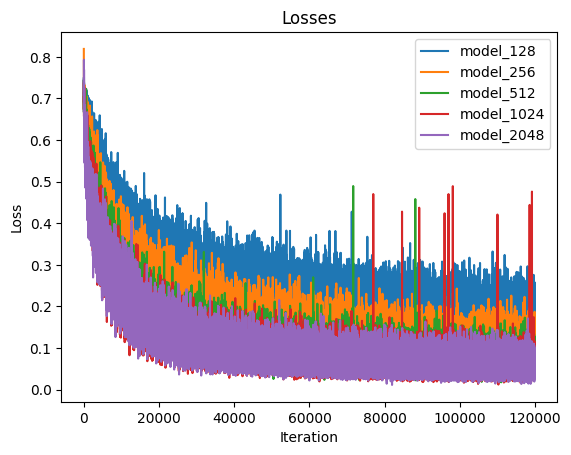

In [ ]:
#results stored on the google drive of Team 8
results_id = {"128":"1F2lr5QE3RuQt3j86dhafqDYatxHSLMVl",
           "256":"17r74vGCn9nLjsLW_KR4_e6DG0_-87rqv",
           "512":"1GOoy54Iws_qV_1gB7PAm1wT1mqG4bptN",
           "1024":"1Y6gkLMXgcZ4Z4ETH2CCbnHKuIbW_QVhC",
           "2048":"1-pBd5QAsQ_xP6Jyx-yEulZyO6V9k_NHt"}

def load_results(file_id, nodes):
    """Accepts a result file ID and node count to load in a DeepDDI model from gdrive"""
    url = f"https://drive.google.com/uc?id={file_id}"
    output = f"model_{nodes}.json"
    gdown.download(url, output, quiet=True)
    with open(output, 'r') as model_results:
        results_json = json.load(model_results)
    return results_json


roc_auc = []
acc = []
recall = []
precision = []
f1 = []
training_time = []
evaluation_time = []
nodes = []
all_losses = []
losses_tr = []

%matplotlib inline
print("The following metrics were saved from the training of our preloaded \n models via the training code demonstrated above. \n")
for node, file_id in results_id.items():
    results_json = load_results(file_id, node)

    nodes.append(int(node))

    print(f"Runtime results for model_{node}:")
    print(f"ROC AUC: {results_json['evaluation']['roc_auc']}")
    print(f"Accuracy: {results_json['evaluation']['acc']}")
    print(f"Recall: {results_json['evaluation']['recall']}")
    print(f"Precision: {results_json['evaluation']['precision']}")
    print(f"F1 Score: {results_json['evaluation']['f1']}")
    print(f"Training Time (s): {float(results_json['training_time'])}")
    #print(f"Evaluation Time (s): {results_json['evaluation_time']}")
    print(f"losses: {results_json['losses'][:3]} ... {results_json['losses'][-3:]}")

    roc_auc.append(results_json['evaluation']['roc_auc'])
    acc.append(results_json['evaluation']['acc'])
    recall.append(results_json['evaluation']['recall'])
    precision.append(results_json['evaluation']['precision'])
    f1.append(results_json['evaluation']['f1'])
    training_time.append(float(results_json['training_time'])/60/60)
    evaluation_time.append(results_json['evaluation_time'])
    losses_tr.append(results_json['losses'])
    plt.plot(results_json['losses'], label=f'model_{node}')

plt.title('Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()
print() #do not remove, prevents duplicate plot bug

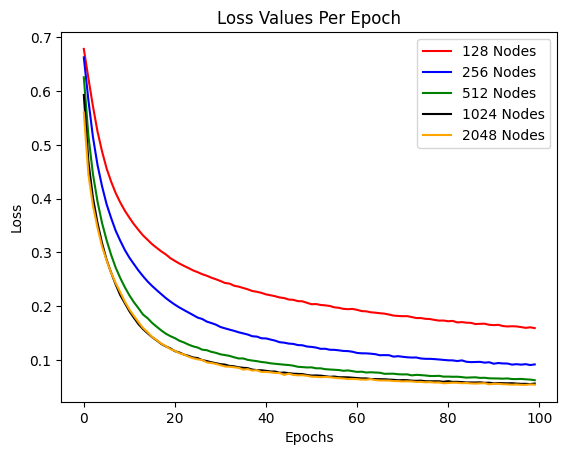

In [ ]:
%matplotlib inline

epoch_averages = []
for loss_list in losses_tr:
    avg_list = []
    epoch_size = len(loss_list) // 100
    for i in range(0, len(loss_list), epoch_size):
        avg = sum(loss_list[i:i+epoch_size]) / epoch_size
        avg_list.append(avg)
    epoch_averages.append(avg_list)
results_nodes = ["128", "256", "512", "1024", "2048"]
df_losses = pd.DataFrame([res for res in epoch_averages])
df_losses.index = [f'{results_nodes[0]} Nodes', f'{results_nodes[1]} Nodes',
            f'{results_nodes[2]} Nodes', f'{results_nodes[3]} Nodes',
            f'{results_nodes[4]} Nodes']
plt.plot(epoch_averages[0],linestyle='-', color='red', label='128 Nodes')
plt.plot(epoch_averages[1],linestyle='-', color='blue', label='256 Nodes')
plt.plot(epoch_averages[2],linestyle='-', color='green', label='512 Nodes')
plt.plot(epoch_averages[3],linestyle='-', color='black', label='1024 Nodes')
plt.plot(epoch_averages[4],linestyle='-', color='orange', label='2048 Nodes')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Values Per Epoch")
plt.legend(loc="upper right")
plt.show()
print() #do not remove, prevents duplicate plot bug

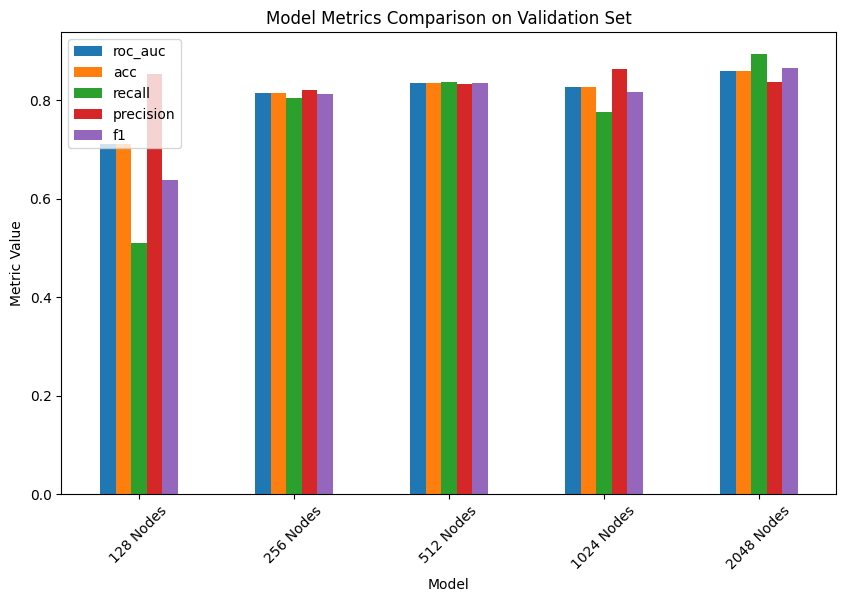

In [ ]:
%matplotlib inline

df_val = pd.DataFrame({
    'roc_auc': roc_auc,
    'acc': acc,
    'recall': recall,
    'precision': precision,
    'f1': f1
})
results_nodes = ["128", "256", "512", "1024", "2048"]
df_val.index = [f'{results_nodes[0]} Nodes', f'{results_nodes[1]} Nodes',
            f'{results_nodes[2]} Nodes', f'{results_nodes[3]} Nodes',
            f'{results_nodes[4]} Nodes']
df_val.plot(kind='bar', figsize=(10, 6))
plt.title("Model Metrics Comparison on Validation Set")
plt.xlabel("Model")
plt.ylabel("Metric Value")
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

print() #do not remove, prevents duplicate plot bug

In [ ]:
def test_fnc(_ddi_model,
         _threshold=0.47,
         metrics=metrics):

    _ddi_model.eval()
    predictions = []

    for test_batch in test_generator:
        prediction = _ddi_model(test_batch.drug_features_left, test_batch.drug_features_right)
        if isinstance(prediction, collections.abc.Sequence):
            prediction = prediction[0]
        prediction = prediction.detach().cpu().numpy()
        identifiers = test_batch.identifiers
        prediction[prediction >= _threshold] = 1
        prediction[prediction < _threshold] = 0
        identifiers["prediction"] = prediction
        predictions.append(identifiers)

    predictions_df = pd.concat(predictions)

    if metrics is None:
        metric_dict = {"roc_auc": roc_auc_score}
    else:
        metric_dict = {name: metric_resolver.lookup(name) for name in metrics}

    return {name: func(predictions_df["label"], predictions_df["prediction"]) \
            for name, func in metric_dict.items()}

In [ ]:
test_results = []
results_nodes = ["128", "256", "512", "1024", "2048"]
for idx, model in enumerate(trained_models):
    print(f"\nTesting model with {results_nodes[idx]} nodes in each layer ...")
    res = test_fnc(model)
    # for k,v in res.items():
        # print(k, ":", round(v, 3))
    test_results.append(res)


Testing model with 128 nodes in each layer ...

Testing model with 256 nodes in each layer ...

Testing model with 512 nodes in each layer ...

Testing model with 1024 nodes in each layer ...

Testing model with 2048 nodes in each layer ...


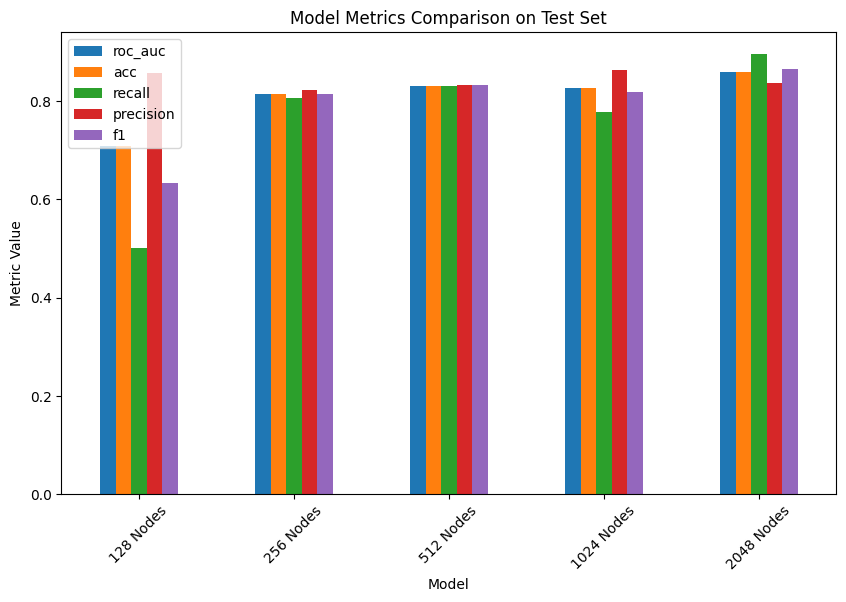

In [ ]:
%matplotlib inline
df_test = pd.DataFrame([res for res in test_results])
df_test.index = [f'{results_nodes[0]} Nodes', f'{results_nodes[1]} Nodes',
            f'{results_nodes[2]} Nodes', f'{results_nodes[3]} Nodes',
            f'{results_nodes[4]} Nodes']
df_test.plot(kind='bar', figsize=(10, 6))
plt.title("Model Metrics Comparison on Test Set")
plt.xlabel("Model")
plt.ylabel("Metric Value")
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

print() #do not remove, prevents duplicate plot bug

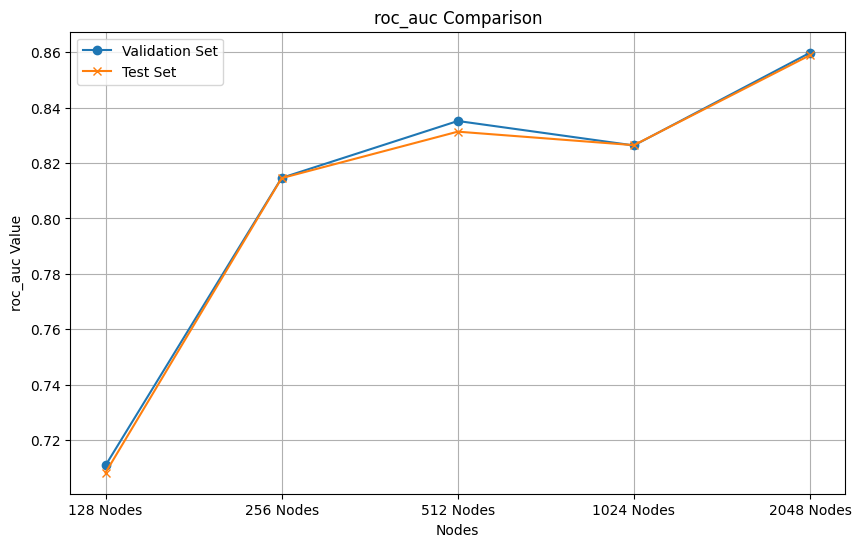

In [ ]:
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.plot(df_val.index, df_val['roc_auc'], marker='o', label='Validation Set')
plt.plot(df_test.index, df_test['roc_auc'], marker='x', label='Test Set')
plt.title("roc_auc Comparison")
plt.xlabel("Nodes")
plt.ylabel("roc_auc Value")
plt.legend()
plt.grid(True)
plt.show()

print() #do not remove, prevents duplicate plot bug

# Discussion

This section reflects on the replication attempt of the original study's findings using the DeepDDI model, providing insights into the reproducibility of the paper, challenges encountered, and potential improvements for future research efforts.
## Assessment of Reproducibility

Based on our experiments, the original paper's results are partially reproducible. The model's performance with a high number of nodes (2048 and 1024) approached the claimed outcomes, suggesting that under optimal conditions and with substantial computational resources, the model can indeed perform at a high level. However, as the number of nodes decreased, there was a noticeable drop in all metrics, particularly with the smallest model (128 nodes), which significantly underperformed.
Challenges in Reproduction

### What Was Easy:

* Model Architecture Implementation: The clear description of the model architecture in the original paper made it straightforward to implement and test various configurations.
* Data Processing and Loading: Utilizing the DrugBank<sup>[4]</sup> dataset and the provided data handling tools facilitated an efficient setup for training and evaluation.

### What Was Difficult:

* Resource Constraints: Training larger models with thousands of nodes required substantial computational resources, which posed a challenge in environments with limited capacity like standard Colab notebooks.
* Reaching Reported Metrics: While the highest configurations nearly reached the reported metrics, achieving consistent results across different settings proved challenging, especially with lower resource models.

### Suggestions for Improving Reproducibility

* Detailed Configuration: Future reproductions would benefit from more detailed descriptions of the training conditions, including specifics on the computational environment and hyperparameter tuning processes.

## Future Plan

### Ablation Study on Feature Selection

In the next phase of our project, we aim to delve deeper into the feature selection process employed in our models. Currently, our approach involves using the first 256 features from the chemical structures, a method that simplifies the preprocessing but may not optimally capture the most informative aspects of the data, given that the total number of features is 2159.

To enhance the effectiveness of our feature selection and potentially improve model performance, we plan to conduct an ablation study comparing our current method with a Principal Component Analysis (PCA) approach. PCA is a powerful technique for dimensionality reduction that transforms a large set of variables into a smaller one that still contains most of the information in the large set. By applying PCA, we hope to:

* Reduce the dimensionality of the chemical structure features from 2159 to a more manageable number, focusing on the components that capture the most variance and, presumably, the most information.
* Identify the most informative features rather than arbitrarily selecting the first 256. This could potentially uncover hidden patterns in the chemical data that are more predictive of drug interactions.

This study will involve:

* Implementing PCA on the entire set of 2159 chemical structure features to reduce them to a principal component space that retains most of the variance.
* Integrating these PCA-transformed features into the ChemicalX framework<sup>[2]</sup> and training the model to assess any changes in performance metrics compared to the baseline model using the first 256 features.
* Evaluating the models on several metrics to compare their effectiveness in predicting drug-drug interactions. We will specifically look at accuracy, precision, recall, F1 score, and AUC to determine if PCA provides a significant benefit.

The outcome of this ablation study will not only inform our feature selection strategy but also contribute to broader research by demonstrating the impact of different feature reduction techniques on the performance of models predicting complex biological interactions. This approach aligns with our commitment to enhancing the reproducibility and reliability of computational tools in drug discovery.


# References

1. Ryu JY, Kim HU, Lee SY (2018) Deep learning improves prediction of drug–drug and drug–food interactions. Proceedings of the National Academy of Sciences 115(18). doi:10.1073/pnas.1803294115.
1. AstraZeneca, ChemicalX: A PyTorch and TorchDrug based deep learning library for drug pair scoring. GitHub repository, 2022. [Online]. Available: https://github.com/AstraZeneca/chemicalx/
1. Fonseca Santiesteban, A., ChemicalX fork for Python 3.10 compatibility. GitHub repository, 2024. [Online]. Available: https://github.com/lucag2/chemicalx#egg=chemicalx
1. Wishart DS, et al. (2017) DrugBank 5.0: A major update to the DrugBank database for 2018. Nucleic Acids Res 46:D1074–D1082.